In [72]:
import os
import pandas as pd
import numpy as np

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans

In [74]:
import re

In [75]:
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))

In [76]:
CLUSTER_COUNT = 20

In [77]:
METHOD = "word2vec_kmeans"
DATA_FOLDER = "data/"
OUTPUT_FOLDER = "output/"
MODEL_FOLDER = "model/"

TITLE_FILE = DATA_FOLDER + "title_StackOverflow.txt"
CHECK_INDEX_FILE = DATA_FOLDER + "check_index.csv"
MODEL_FILE = MODEL_FOLDER + "w2v_with-title_1000feature_10minwords_10iter"

In [78]:
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

# Read and cleaning data

In [79]:
# substitute symbols with whitespaces, to lowercase
def sentenceToCleanWordSeqs(s):
    return [w for w in re.sub("[^a-zA-Z]", " ", s).lower().split() if not w in stops]

In [80]:
with open(TITLE_FILE) as f:
    titles = f.read().splitlines()

In [81]:
clean_title_word_seqs = [sentenceToCleanWordSeqs(title) for title in titles]

In [82]:
clean_title_word_seqs[:10]

[['fill', 'dataset', 'datatable', 'linq', 'query', 'resultset'],
 ['page', 'collection', 'linq'],
 ['best', 'subversion', 'clients', 'windows', 'vista', 'bit'],
 ['best',
  'practice',
  'collaborative',
  'environment',
  'bin',
  'directory',
  'svn'],
 ['visual',
  'studio',
  'setup',
  'project',
  'per',
  'user',
  'registry',
  'settings'],
 ['elegantly', 'express', 'left', 'join', 'aggregate', 'sql', 'linq', 'query'],
 ['net', 'xml', 'comment', 'api', 'documentation'],
 ['modify',
  'address',
  'bar',
  'url',
  'ajax',
  'app',
  'match',
  'current',
  'state'],
 ['integrating', 'visual', 'studio', 'test', 'project', 'cruise', 'control'],
 ['longtime', 'windows', 'user', 'know', 'starting', 'use', 'linux']]

# Extract Features

In [83]:
from gensim.models import Word2Vec
w2v_model = Word2Vec.load(MODEL_FILE)
index2word_set = set(w2v_model.index2word)
num_features = w2v_model.syn0.shape[1]

In [84]:
w2v_model.most_similar("vs")

[('vc', 0.6702888011932373),
 ('visualstudio', 0.6470158100128174),
 ('debugger', 0.5769426822662354),
 ('xcode', 0.5612576007843018),
 ('eclipse', 0.5576363205909729),
 ('mingw', 0.5571197867393494),
 ('exe', 0.5404865741729736),
 ('qtcreator', 0.5351230502128601),
 ('dll', 0.5250240564346313),
 ('qmake', 0.5237623453140259)]

In [85]:
# avg_vec = np.zeros((num_features,),dtype="float32")
# total_count = 0

# for ws in clean_title_word_seqs:
#     featureVec = np.zeros((num_features,),dtype="float32")
#     count = 0
#     for w in ws:
#         if w in index2word_set:
#             count += 1
#             total_count += 1
#             featureVec += w2v_model[w]
#             avg_vec += w2v_model[w]
#     if count > 0:
#         featureVec /= count
#     title_vecs.append(featureVec)
    
# avg_vec /= total_count

In [86]:
title_vecs = []

for ws in clean_title_word_seqs:
    featureVec = np.zeros((num_features,),dtype="float32")
    count = 0
    for w in ws:
        if w in index2word_set:
            count += 1
            featureVec += w2v_model[w]
    if count > 0:
        featureVec /= count
    else:
        print(ws)
    title_vecs.append(featureVec)
    
title_vecs = np.array(title_vecs)

['progressive', 'enhancement']
['maskededitextender']
['unfiltering', 'nspasteboard']
['stringstream', 'manipulators', 'vstudio']
['linqify']
['ajaxify']
['portalsitemapprovider']
['nsmanagedobjectcontextobjectswillchangenotification']
['vssettings']
['cgbitmapcontext', 'bitmapcontext']
['listtemplateowner']
['uiwebview', 'multithread', 'viewcontroller']
['uinavigationcontroller', 'autorotation']
['pushd', 'popd', 'ksh']
['setquerytimeout', 'simplejdbctemplate']
['floatvalue', 'cgfloat']
['animating', 'nsdrawer']
['htcaccess', 'modrewrite']
['macid']
['cgwindowid', 'axuielement']
['qtpython', 'removechild', 'addchild', 'qgroupbox']
['qabstractsocket', 'unknownsocketerror']
['kext']
['xlshtml']
['jpatamplate', 'autocommit']
['etl', 'esper', 'drools']


In [92]:
# lsa
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd = TruncatedSVD(20)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

title_vecs_lsa = lsa.fit_transform(title_vecs)

In [93]:
title_vecs_lsa

array([[ 0.55039386,  0.61745062, -0.29672747, ...,  0.10141526,
         0.10213984, -0.12702088],
       [ 0.61783593,  0.18098015, -0.42473836, ...,  0.16945103,
         0.00436111, -0.23357334],
       [ 0.25033621, -0.48412724,  0.63550865, ...,  0.03234976,
        -0.1437222 , -0.06945906],
       ..., 
       [ 0.53880156, -0.42118677, -0.42941789, ..., -0.12891905,
        -0.01625044,  0.00865129],
       [ 0.40982346, -0.56971975,  0.17546881, ..., -0.21373959,
        -0.07800356,  0.12536061],
       [ 0.6097553 ,  0.40847302, -0.34783933, ..., -0.16346196,
        -0.20467865,  0.00435352]])

# Visualize

In [58]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD, PCA
import matplotlib.pyplot as plt

In [61]:
pca = PCA(n_components=2)
pca.fit(title_vecs)
Y = pca.transform(title_vecs)

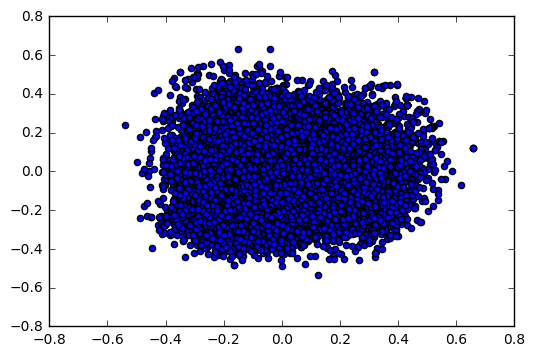

In [71]:
plt.scatter(Y[:,0], Y[:,1])
plt.show()

In [35]:
# model = TSNE(n_components=2, random_state=0)
# np.set_printoptions(suppress=True)
# Y = model.fit_transform(title_vecs)

# Clustering

In [97]:
# model = MiniBatchKMeans(n_clusters=CLUSTER_COUNT, init='k-means++', n_init=1, init_size=1000, batch_size=1000, max_iter=500)
model = KMeans(n_clusters=CLUSTER_COUNT, init='k-means++', max_iter=100, n_init=1)
model.fit(title_vecs_lsa)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=20, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [98]:
title_clusters = np.array(model.labels_.tolist())

In [99]:
from scipy.stats import entropy

unique, counts = np.unique(title_clusters, return_counts=True)
print(entropy(counts))
print(np.asarray((unique, counts)).T)

2.99075041575
[[   0 1192]
 [   1  861]
 [   2  970]
 [   3 1003]
 [   4  998]
 [   5  969]
 [   6 1122]
 [   7 1059]
 [   8  847]
 [   9 1019]
 [  10 1078]
 [  11  998]
 [  12  863]
 [  13 1100]
 [  14 1075]
 [  15 1127]
 [  16  998]
 [  17  996]
 [  18  902]
 [  19  823]]


In [47]:
entropy([1]*20)

2.9957322735539909

# output

In [100]:
checkIndexDF = pd.read_csv(CHECK_INDEX_FILE)

In [101]:
checkIndexDF.head()

,ID,x_ID,y_ID
0,0,11726,1565
1,1,16528,7523
2,2,16683,19401
3,3,6506,5239
4,4,10279,19928


In [102]:
checkIndexDF["Ans"] = (title_clusters[checkIndexDF["x_ID"]] == title_clusters[checkIndexDF["y_ID"]]).astype(int)

In [103]:
checkIndexDF.head(20)

,ID,x_ID,y_ID,Ans
0,0,11726,1565,0
1,1,16528,7523,0
2,2,16683,19401,0
3,3,6506,5239,0
4,4,10279,19928,0
5,5,19846,2428,0
6,6,3532,18102,0
7,7,11502,9753,0
8,8,13470,18420,0
9,9,4867,4793,0


In [104]:
checkIndexDF.to_csv(OUTPUT_FOLDER + METHOD + "_w2v-1000_lsa20.csv", columns=["ID", "Ans"], index=False)